# import y funciones

In [11]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
import pandas as pd
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import zipfile
import requests
import io
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pmdarima.arima import auto_arima
import statsmodels.formula.api as smf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import time
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pickle
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
FILE_NAME_CSV_DATASET_CLIMA = 'https://raw.githubusercontent.com/PabloSGomez50/humai-solar-panels/main/scraper_clima/clima_sydney_limpio3.csv'
FILE_NAME_CSV_DATASET_PRODUCCION = 'https://github.com/PabloSGomez50/humai-solar-panels/blob/main/script_produccion/produccion.csv.zip?raw=true'

def get_dataset_clima():
  df_clima = pd.read_csv(FILE_NAME_CSV_DATASET_CLIMA)
  df_clima.drop(columns=['Unnamed: 0'], inplace = True)
  df_clima.rename(columns={'Date': 'Datetime'}, inplace = True)    

  # elimino dos registros que estaban duplicados
  dupli_1_index = df_clima[(df_clima.Datetime == '2013-04-07 02:00:00') & (df_clima.Barometer == 1023)].index
  dupli_2_index = df_clima[(df_clima.Datetime == '2013-04-07 02:30:00') & (df_clima.Barometer == 1023)].index
  df_clima = df_clima.drop(df_clima.index[dupli_1_index]).drop(df_clima.index[dupli_2_index]) 

  df_clima['Datetime'] = pd.to_datetime(df_clima['Datetime'], format='%Y-%m-%d %H:%M:%S')
  df_clima['Hora'] = df_clima.Datetime.dt.hour    
  df_clima['Mes'] = df_clima.Datetime.dt.month


  return df_clima

def get_dataset_produccion():
  content = requests.get(FILE_NAME_CSV_DATASET_PRODUCCION).content
  zip_file = zipfile.ZipFile(io.BytesIO(content))
  file = zip_file.open("produccion.csv")
  df_produccion = pd.read_csv(file)
  df_produccion.rename(columns={'datetime': 'Datetime'}, inplace = True)
  df_produccion['Datetime'] = pd.to_datetime(df_produccion['Datetime'], format='%Y-%m-%d %H:%M:%S')

  return df_produccion

def join_dataset(df_clima, df_produccion, customer_id):

  # me quedo con un unico customer_id
  df_produccion_only_one_customer = df_produccion[df_produccion.Customer == customer_id]
  df_produccion_only_one_customer.drop(columns='Customer', inplace = True)

  # luego de este join van a aparecer muchos registros con los datos del clima en NaN
  df_join = df_produccion_only_one_customer.merge(df_clima, left_on="Datetime", right_on="Datetime", how="left")

  # casteo la fecha para que sea datatime
  df_join['Datetime'] = pd.to_datetime(df_join['Datetime'], format='%Y-%m-%d %H:%M:%S')

  # Ordeno el dataset para que la imputacion por el valor anterior funcione correctamente
  df_join.sort_values(by ='Datetime', inplace=True)
  df_join.fillna(method = 'ffill', inplace = True)

  df_join['Hora'] = df_join['Hora'].astype(int)
  df_join['Mes'] = df_join['Mes'].astype(int)
  df_join['Temp'] = df_join['Temp'].astype(int)
  df_join['Wind'] = df_join['Wind'].astype(int)
  df_join['Humidity'] = df_join['Humidity'].astype(int)
  df_join['Barometer'] = df_join['Barometer'].astype(int)
  df_join['Visibility'] = df_join['Visibility'].astype(int)

  columns_rename = {
      'Temp': 'Temperatura',
      'Weather': 'Clima',
      'Wind': 'Viento',
      'Humidity': 'Humedad',
      'Barometer': 'Presion_atmosferica',
      'Visibility': 'Visibilidad',
      'Partly sunny': 'Partly_sunny',
      'Passing clouds': 'Passing_clouds',
      'Scattered clouds': 'Scattered_clouds'
  }

  df_join.rename(columns=columns_rename, inplace = True)    


  # Seteo la fecha como index y establezco la frecuencia    
  df_join.set_index("Datetime", inplace=True)
  df_join = df_join.asfreq('30T')

  return df_join

def grafico_barras_promedio(feature):

  df_mean = df_join.groupby(feature).aggregate({'Produccion': 'mean'})

  # Crear el gráfico de barras
  plt.figure(figsize=(20, 7))
  df_mean = df_mean.sort_values(by='Produccion')
  plt.bar(df_mean.index, df_mean['Produccion'])

  # Añadir etiquetas y títulos
  plt.xlabel(feature)
  plt.ylabel('Promedio de la producción')
  plt.title('Promedio de la producción energetica segun ' + feature)

  # Mostrar el gráfico
  plt.show()    

def test_adfuller(df):
  result = adfuller(df)

  print("ADF: ", result[0])
  print("p-value: ", result[1])
  print("nobs: ", result[2])
  print("critical values: ", result[4])
  print("usedlag: ", result[3])

from datetime import datetime, timedelta


def predict_plot(model, df_train, df_test, periods_before, periods_predict, columns_exog = None):
  date_from = df_test.reset_index()["Datetime"].min()
  date_to = date_from + timedelta(hours=periods_predict)


  # Obtener la predicción y los intervalos de confianza
  if columns_exog is None:
    preds = model.get_prediction(start=date_from, end=date_to, dynamic=False)
  else:
    preds = model.get_prediction(start=date_from, end=date_to, dynamic=False, exog=df_test.loc[date_from:date_to][columns_exog])
  pred_conf = preds.conf_int(alpha=0.9)

  # Graficar los datos de entrenamiento, prueba y predicción, y las bandas de confianza
  plt.figure(figsize=(20, 10))
  plt.plot(df_train['Produccion'][-periods_before:], label='Train', color='blue')
  plt.plot(df_test['Produccion'][:periods_predict], label='Test', color='blue', linestyle='--')
  plt.plot(preds.predicted_mean, label='Forecast', color='magenta')
  plt.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='gray', alpha=0.6)
  plt.legend(loc='upper left')
  plt.show()


def RMSE(predicted, actual):
    mse = (predicted - actual)**2
    rmse = np.sqrt(mse.sum()/mse.count())
    return rmse

def get_RMSE (model, df_test, periods_predict, columns_exog = None):

  date_from = df_test.reset_index()["Datetime"].min()
  date_to = date_from + timedelta(hours=periods_predict)


  # Obtener la predicción y los intervalos de confianza
  if columns_exog is None:
    predicted = model.get_prediction(start=date_from, end=date_to, dynamic=False)
  else:
    predicted = model.get_prediction(start=date_from, end=date_to, dynamic=False, exog=df_test.loc[date_from:date_to][columns_exog])
  
  actual = df_test.loc[date_from:date_to].Produccion

  mse = (predicted.predicted_mean - actual)**2
  rmse = np.sqrt(mse.sum()/mse.count())
  return rmse    

# Guardamos todo en un dataframe
dfModelsResults = pd.DataFrame(columns = ["Model", "AIC", "RMSE", "Time"])

def put_model_result(df, model_name, aic, time, rmse):

  if df[df.Model == model_name].shape[0] == 1:  
    index = df[df.Model == model_name].index.values.tolist()[0]
  else:
    index = df.shape[0]
  df.loc[index,"Model"] = model_name
  df.loc[index,"AIC"] = aic
  df.loc[index,"RMSE"] = rmse
  df.loc[index,"Time"] = time

  return df  

In [14]:
df_clima = get_dataset_clima()
df_produccion = get_dataset_produccion()


In [15]:
Customer_id = 17
df_join = join_dataset(df_clima, df_produccion, Customer_id)

resample = df_join.resample(rule="1H")
join_resaple = resample['Produccion'].sum()
df_join_resample = pd.DataFrame(join_resaple)
df_join_resample['Temperatura'] = resample['Temperatura'].mean()
df_join_resample['Viento'] = resample['Viento'].mean()
df_join_resample['Humedad'] = resample['Humedad'].mean()
df_join_resample['Presion_atmosferica'] = resample['Presion_atmosferica'].mean()
df_join_resample['Visibilidad'] = resample['Visibilidad'].mean()
df_join_resample['Clear'] = resample['Clear'].first()
df_join_resample['Partly_sunny'] = resample['Partly_sunny'].first()
df_join_resample['Passing_clouds'] = resample['Passing_clouds'].first()
df_join_resample['Scattered_clouds'] = resample['Scattered_clouds'].first()
df_join_resample['Sunny'] = resample['Sunny'].first()
df_join_resample['Clima'] = resample['Clima'].first()
df_join_resample['Hora'] = resample['Hora'].first()
df_join_resample['Mes'] = resample['Mes'].first()
df_join_resample = df_join_resample.asfreq('1H')
df_join_resample

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Produccion,Temperatura,Viento,Humedad,Presion_atmosferica,Visibilidad,Clear,Partly_sunny,Passing_clouds,Scattered_clouds,Sunny,Clima,Hora,Mes
Datetime,,,,,,,,,,,,,,
2012-07-01 00:00:00,0.0,12.0,11.0,54.0,1014.0,16.0,1.0,0.0,0.0,0.0,0.0,Clear,0,7
2012-07-01 01:00:00,0.0,12.0,9.0,54.0,1014.0,16.0,1.0,0.0,0.0,0.0,0.0,Clear,1,7
2012-07-01 02:00:00,0.0,11.0,4.5,60.5,1014.0,16.0,1.0,0.0,0.0,0.0,0.0,Clear,2,7
2012-07-01 03:00:00,0.0,11.0,13.0,62.0,1014.0,16.0,1.0,0.0,0.0,0.0,0.0,Clear,3,7
2012-07-01 04:00:00,0.0,10.0,9.0,69.0,1014.0,16.0,1.0,0.0,0.0,0.0,0.0,Clear,4,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-06-30 19:00:00,0.0,13.5,22.0,94.0,1024.0,8.0,0.0,0.0,1.0,0.0,0.0,Passing clouds,19,6
2013-06-30 20:00:00,0.0,13.0,16.0,88.0,1024.0,8.0,0.0,0.0,1.0,0.0,0.0,Passing clouds,20,6
2013-06-30 21:00:00,0.0,12.5,16.0,91.0,1024.0,8.0,0.0,0.0,1.0,0.0,0.0,Passing clouds,21,6


# Estacionalidad,ACF y PACF

## Produccion

In [6]:
test_adfuller(df_join_resample.Produccion)

ADF:  -8.614816132352402
p-value:  6.332279595762151e-14
nobs:  25
critical values:  {'1%': -3.4310989378240957, '5%': -2.8618709806843423, '10%': -2.5669461760495387}
usedlag:  8734


<Figure size 1440x720 with 0 Axes>

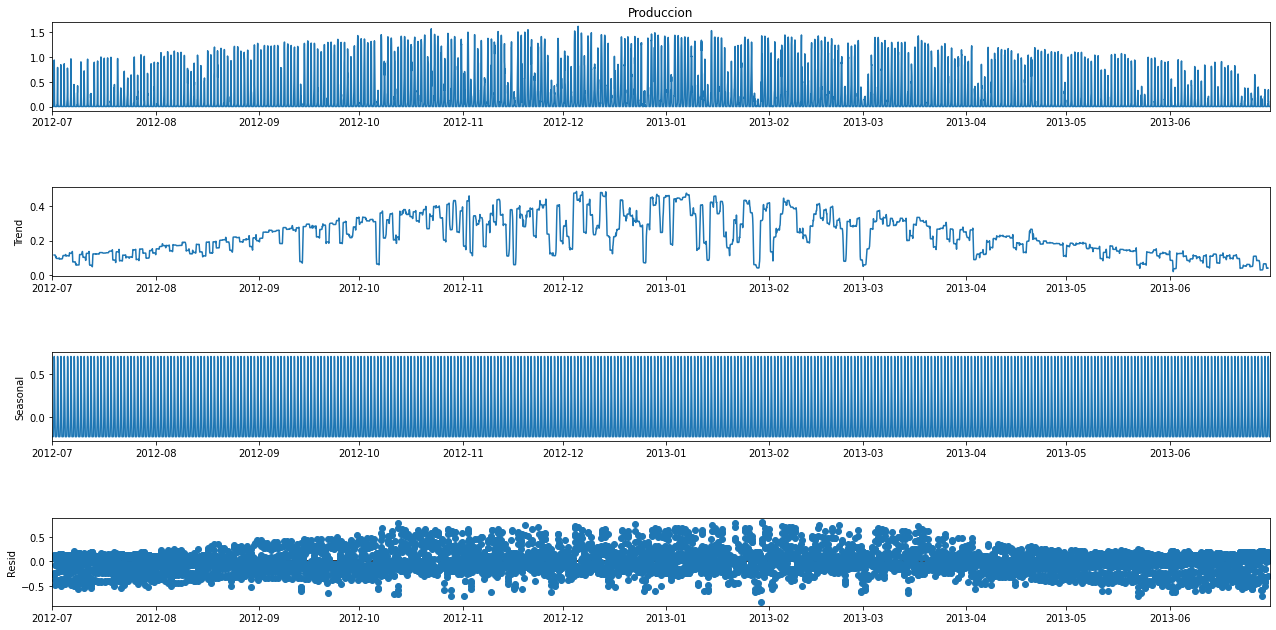

In [7]:
#s_dec_additive_24 = seasonal_decompose(df_join_resample.Produccion.loc['2012-08-01 00:00:00':'2012-08-30 23:30:00'], model="additive", period=24)
s_dec_additive_24 = seasonal_decompose(df_join_resample.Produccion, model="additive", period=24)

plt.figure(figsize=(20, 10))
s_dec_additive_24.plot()
plt.gcf().set_size_inches(20, 10)
plt.show()

<Figure size 1440x720 with 0 Axes>

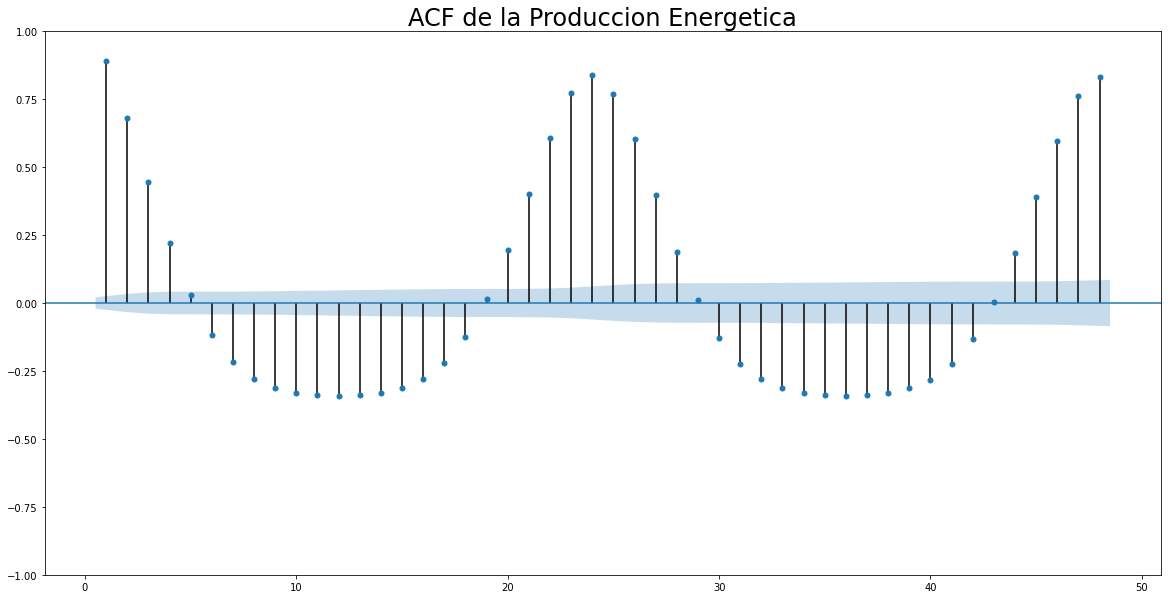

In [8]:
plt.figure(figsize=(20,10))
sgt.plot_acf(df_join_resample.Produccion, lags = (24 * 2), zero = False)
plt.title("ACF de la Produccion Energetica", size = 24)
plt.gcf().set_size_inches(20, 10)
plt.show()


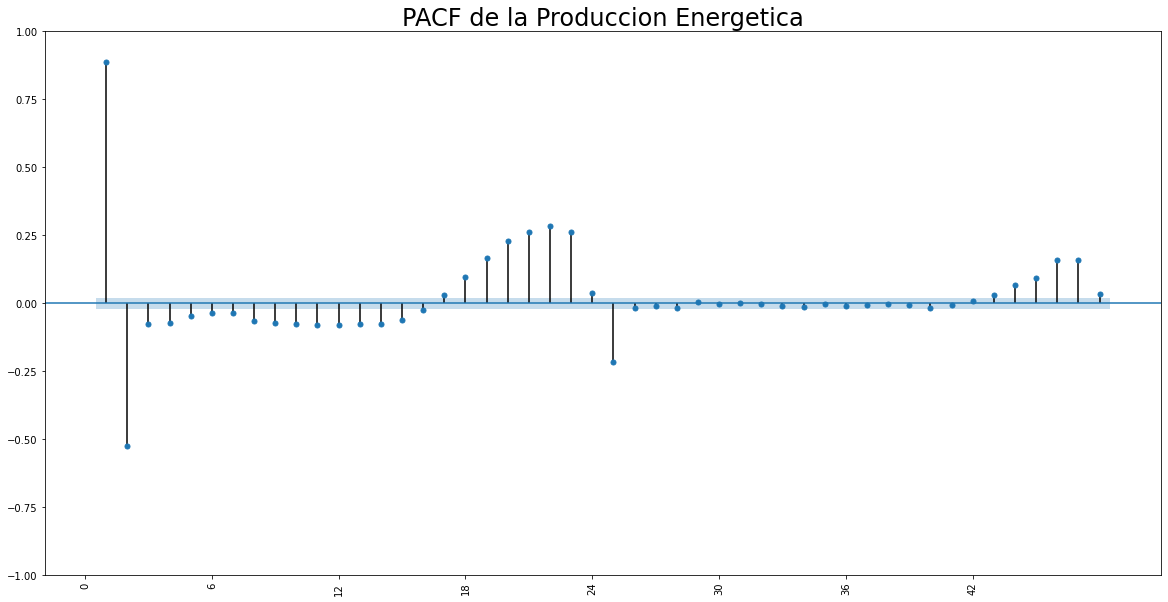

In [9]:
sgt.plot_pacf(df_join_resample.Produccion, lags = (24 * 2), zero = False, method = ('ols'))
plt.xticks(np.arange(0, 24*2, 6), rotation=90)

plt.title("PACF de la Produccion Energetica", size = 24)
plt.gcf().set_size_inches(20, 10)

plt.show()

## Produccion diff 1

In [10]:
df_join_resample["Produccion_diff_1"] =  df_join_resample.Produccion.diff(1)

In [11]:
test_adfuller(df_join_resample.Produccion_diff_1[1:])

ADF:  -41.904564849351885
p-value:  0.0
nobs:  23
critical values:  {'1%': -3.431098852059003, '5%': -2.8618709427866547, '10%': -2.5669461558763422}
usedlag:  8735


<Figure size 1440x720 with 0 Axes>

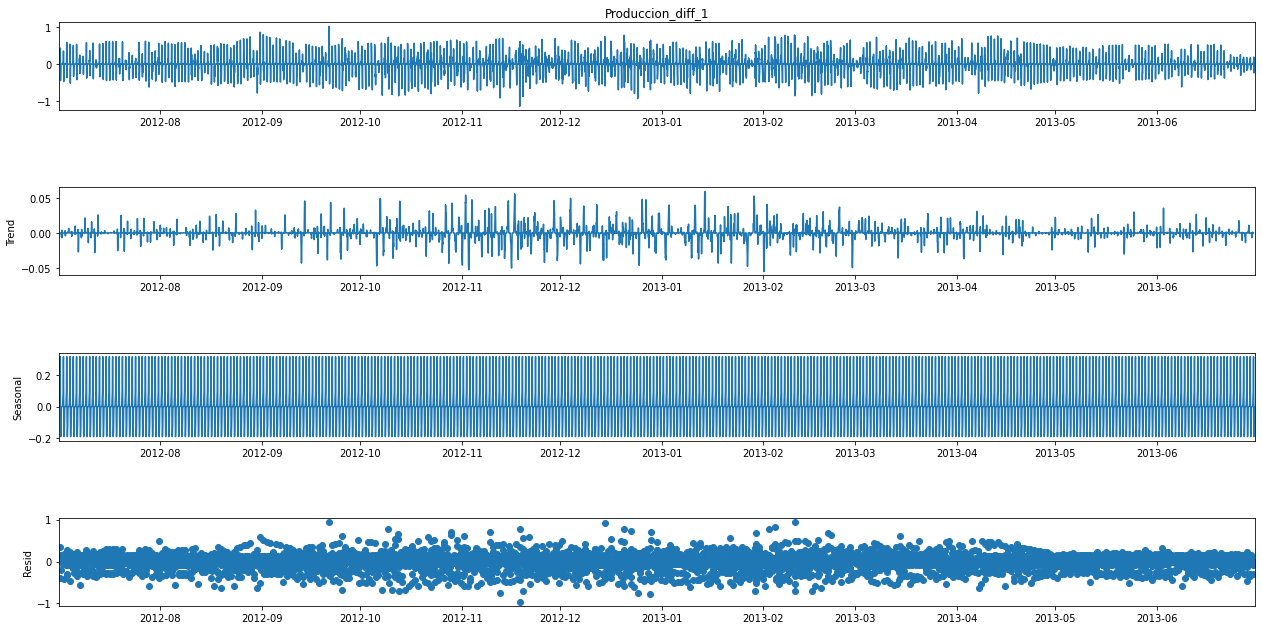

In [12]:
#s_dec_additive_24 = seasonal_decompose(df_join_resample.Produccion.loc['2012-08-01 00:00:00':'2012-08-30 23:30:00'], model="additive", period=24)
s_dec_additive_24_diff = seasonal_decompose(df_join_resample.Produccion_diff_1[1:], model="additive", period=24)

plt.figure(figsize=(20, 10))
s_dec_additive_24_diff.plot()
plt.gcf().set_size_inches(20, 10)
plt.show()

<Figure size 1440x720 with 0 Axes>

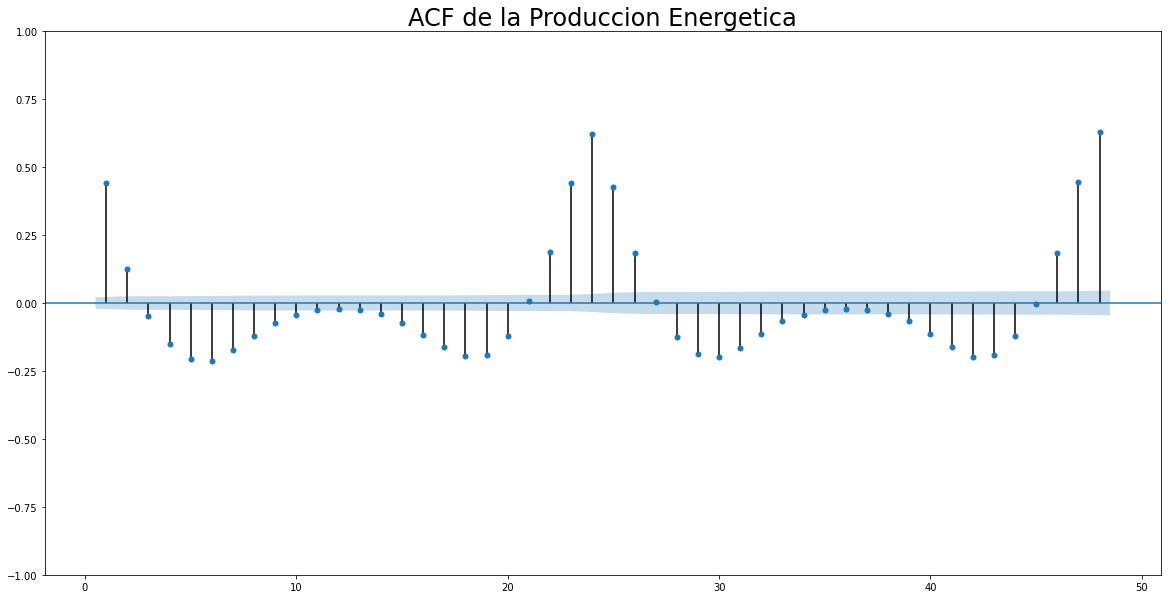

In [13]:
plt.figure(figsize=(20,10))
sgt.plot_acf(df_join_resample.Produccion_diff_1[1:], lags = (24 * 2), zero = False)
plt.title("ACF de la Produccion Energetica", size = 24)
plt.gcf().set_size_inches(20, 10)
plt.show()


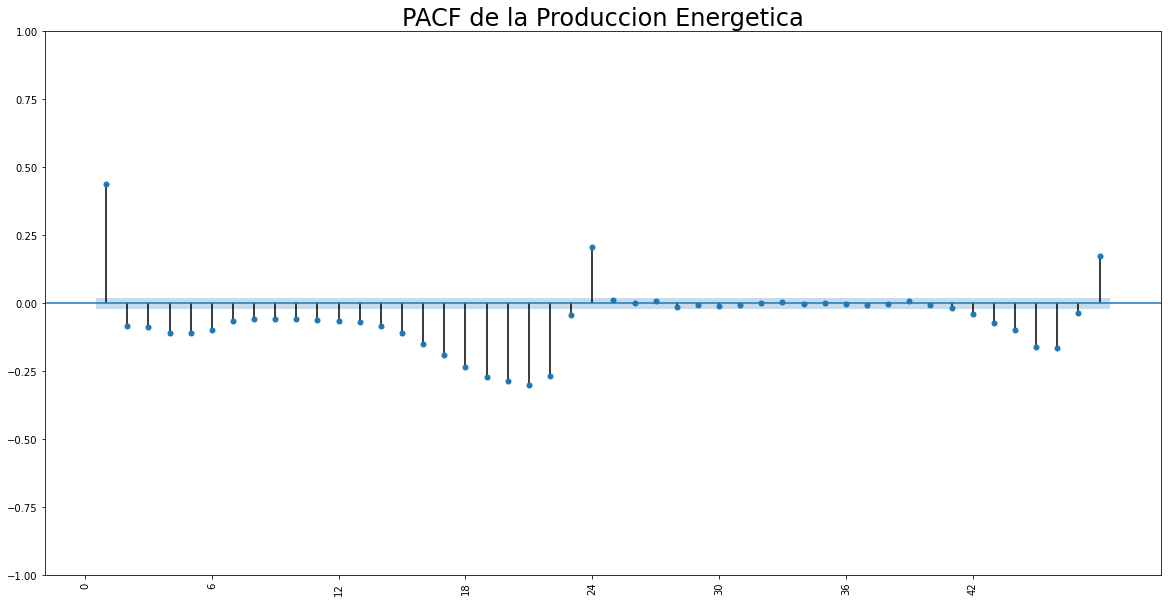

In [14]:
sgt.plot_pacf(df_join_resample.Produccion_diff_1[1:], lags = (24 * 2), zero = False, method = ('ols'))
plt.xticks(np.arange(0, 24*2, 6), rotation=90)

plt.title("PACF de la Produccion Energetica", size = 24)
plt.gcf().set_size_inches(20, 10)

plt.show()

## timeIndex + split

In [16]:
# Agrego una columna que le de un orden a los registros comenzando por 0 e incrementandose de 1 en 1
df_join["timeIndex"] = df_join.index - df_join.index.min()
df_join["timeIndex"] =  df_join["timeIndex"]/np.timedelta64(30, 'm')
df_join["timeIndex"] = df_join["timeIndex"].round(0).astype(int)

df_join_resample["timeIndex"] = df_join_resample.index - df_join.index.min()
df_join_resample["timeIndex"] =  df_join_resample["timeIndex"]/np.timedelta64(60, 'm')
df_join_resample["timeIndex"] = df_join_resample["timeIndex"].round(0).astype(int)


# guardo 1 semana de datos para testear
split = len(df_join) - (48 * 30)
df_train = df_join[:split]
df_test = df_join[split:]

split_resample = len(df_join_resample) - (24 * 7 * 8)
df_train_resample = df_join_resample[:split_resample]
df_test_resample = df_join_resample[split_resample:]

#hago otro split para train, test y validacion
df_train_24 = df_train_resample
split_validation = len(df_test_resample) - (24 * 7 * 4)
df_test_24 = df_test_resample[:split_validation]
df_validation_24 = df_test_resample[split_validation:]

# Experimentos Modelos

## autoarima --> SARIMAX(3, 0, 1) AIC=-8317.251

In [ ]:
step_wise=auto_arima(df_join_resample.Produccion, 
  #exogenous= train_X,
  start_p=1, start_q=1, 
  max_p=24, max_q=24, 
  d=0, max_d=0,
  trace=True, 
  error_action='ignore', 
  suppress_warnings=True, 
  stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-7281.801, Time=8.62 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8447.229, Time=1.64 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-5259.424, Time=2.57 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-141.909, Time=6.89 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=11033.781, Time=1.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-8145.699, Time=10.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-8072.998, Time=1.07 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-8317.251, Time=20.71 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-8124.362, Time=1.55 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-8301.047, Time=21.83 sec


In [ ]:
step_wise.summary()


## Autoarima + exog --> ARIMA(3,0,1)(0,0,0)[0] AIC=-8317.251

In [ ]:
columns_exog = ['Temperatura', 'Viento', 'Humedad',
       'Presion_atmosferica', 'Visibilidad', 'Clear', 'Partly_sunny',
       'Passing_clouds', 'Scattered_clouds', 'Sunny', 'Hora']
       
step_wise_2 =auto_arima(df_join_resample.Produccion, 
  exogenous= df_join_resample[columns_exog],
  start_p=1, start_q=1, 
  max_p=7, max_q=7, 
  d=0, max_d=0,
  trace=True, 
  error_action='ignore', 
  suppress_warnings=True, 
  stepwise=True)

## autoarima + exogenas + estacionalidad --> falla x memoria

In [ ]:
columns_exog = ['Temperatura', 'Viento', 'Humedad',
       'Presion_atmosferica', 'Visibilidad', 'Clear', 'Partly_sunny',
       'Passing_clouds', 'Scattered_clouds', 'Sunny', 'Hora']
       
step_wise_3 =auto_arima(df_join_resample.Produccion, 
  exogenous= df_join_resample[columns_exog],
  start_p=0, start_q=0, 
  max_p=3, max_q=2, 
  d=0, max_d=0,
  start_P=0, start_Q=0, 
  max_P=2, max_Q=2, 
  D=0, max_D=0,
  m=24,
  trace=True, 
  error_action='ignore', 
  suppress_warnings=True, 
  stepwise=True)

## arima (3,0,1) con dataset completo --> AIC	-8321.049

In [16]:
arima_3_0_1_all = sm.tsa.arima.ARIMA(df_join_resample.Produccion, order=(3,0,1)).fit()
print(arima_3_0_1_all.summary())

                               SARIMAX Results                                
Dep. Variable:             Produccion   No. Observations:                 8760
Model:                 ARIMA(3, 0, 1)   Log Likelihood                4166.524
Date:                Thu, 16 Feb 2023   AIC                          -8321.049
Time:                        05:53:09   BIC                          -8278.581
Sample:                    07-01-2012   HQIC                         -8306.579
                         - 06-30-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2298      0.011     21.795      0.000       0.209       0.250
ar.L1          2.1105      0.034     62.464      0.000       2.044       2.177
ar.L2         -1.4851      0.047    -31.576      0.0

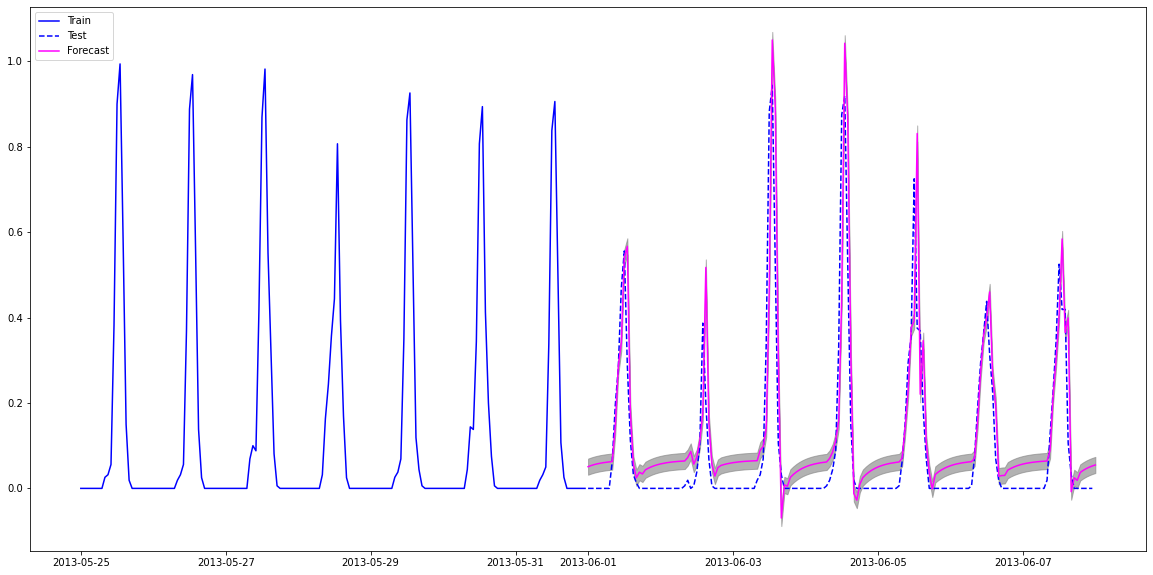

In [17]:
predict_plot(arima_3_0_1_all, df_train_resample, df_test_resample, 24*7, 24 * 7)

## ARIMA (3,0,1) --> AIC -7289.687

In [19]:
inicio = time.time()
arima_3_0_1 = sm.tsa.arima.ARIMA(df_train_resample.Produccion, order=(3,0,1)).fit()
fin = time.time()
print(arima_3_0_1.summary())


                               SARIMAX Results                                
Dep. Variable:             Produccion   No. Observations:                 8040
Model:                 ARIMA(3, 0, 1)   Log Likelihood                3650.844
Date:                Thu, 16 Feb 2023   AIC                          -7289.687
Time:                        05:53:54   BIC                          -7247.734
Sample:                    07-01-2012   HQIC                         -7275.331
                         - 05-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2428      0.010     23.767      0.000       0.223       0.263
ar.L1          2.1165      0.030     71.396      0.000       2.058       2.175
ar.L2         -1.4908      0.042    -35.621      0.0

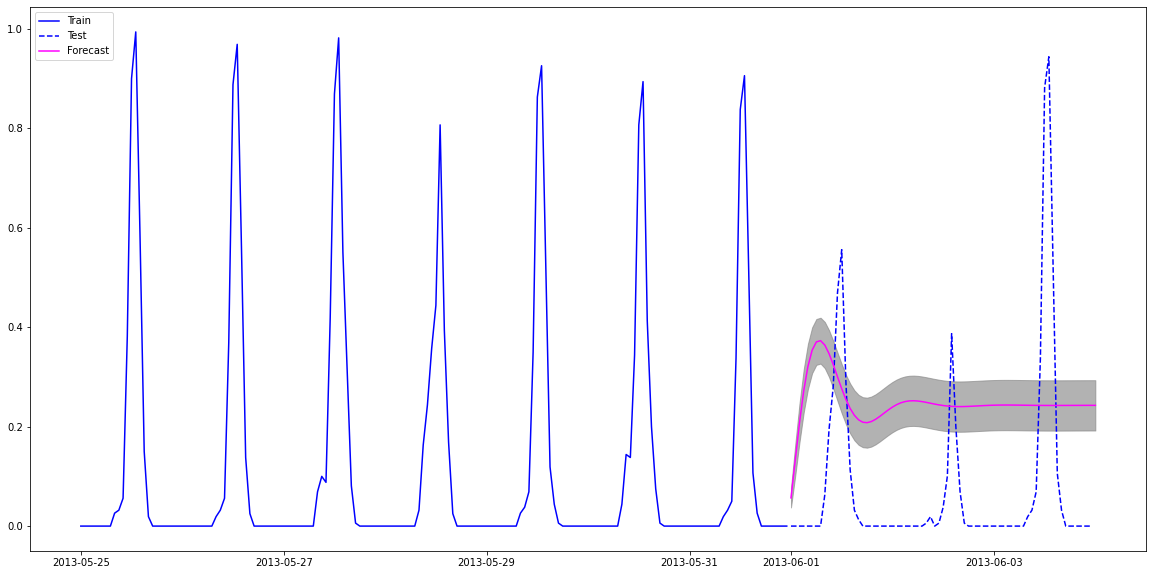

In [20]:
predict_plot(arima_3_0_1, df_train_resample, df_test_resample, 24*7, 24 * 3)

In [21]:
aic = arima_3_0_1.aic
rmse = get_RMSE(arima_3_0_1, df_test_resample, 24 * 3)

put_model_result(dfModelsResults, "ARIMA(3, 0, 1)", aic, fin-inicio, rmse)

,Model,AIC,RMSE,Time
0,"ARIMA(3, 0, 1)",-7289.68708,0.252485,19.24858


In [25]:
#pickle.dump(arima_3_0_1, open('arima_3_0_1.pkl', 'wb'))
file_name = '/content/drive/My Drive/solar_panel_models/arima_3_0_1.pkl'
pickle.dump(arima_3_0_1, open(file_name, 'wb'))

## SARIMAX (1,0,1)(1,0,0,24) --> AIC -9005.564

In [26]:
columns_exog = ['Temperatura', 'Viento', 'Humedad',
       'Presion_atmosferica', 'Visibilidad', 'Clear', 'Partly_sunny',
       'Passing_clouds', 'Scattered_clouds', 'Sunny', 'Hora']
       
inicio = time.time()
sarimax_1_0_1_1_0_0_24 = SARIMAX(df_train_resample.Produccion, exog = df_train_resample[columns_exog], order=(1,0,1), seasonal_order=(1, 0, 0, 24)).fit()
fin = time.time()
print(sarimax_1_0_1_1_0_0_24.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:                          Produccion   No. Observations:                 8040
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 24)   Log Likelihood                4517.782
Date:                             Thu, 16 Feb 2023   AIC                          -9005.564
Time:                                     05:59:39   BIC                          -8900.681
Sample:                                 07-01-2012   HQIC                         -8969.673
                                      - 05-31-2013                                         
Covariance Type:                               opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Temperatura             0.0168      0.002      9.996      0.000       0.014       0.020


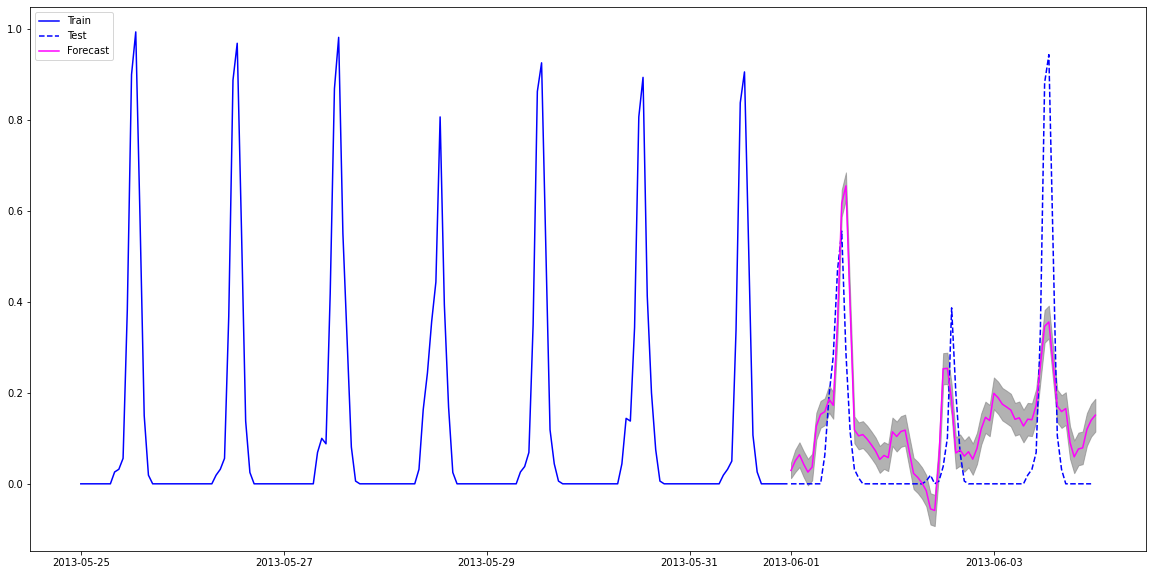

In [27]:
predict_plot(sarimax_1_0_1_1_0_0_24, df_train_resample, df_test_resample, 24*7, 24 * 3, columns_exog)

In [28]:
aic = sarimax_1_0_1_1_0_0_24.aic
rmse = get_RMSE(sarimax_1_0_1_1_0_0_24, df_test_resample, 24 * 3, columns_exog)

put_model_result(dfModelsResults, "SARIMAX (1,0,1)(1,0,0,24)", aic, fin-inicio, rmse)

,Model,AIC,RMSE,Time
0,"ARIMA(3, 0, 1)",-7289.68708,0.252485,19.24858
1,"SARIMAX (1,0,1)(1,0,0,24)",-9005.564161,0.153444,206.57056


In [29]:
file_name = '/content/drive/My Drive/solar_panel_models/sarimax_1_0_1_1_0_0_24.pkl'
pickle.dump(sarimax_1_0_1_1_0_0_24, open(file_name, 'wb'))

## SARIMAX (1,0,1)(1,0,1,24) --> AIC -9843.267

In [30]:
columns_exog = ['Temperatura', 'Viento', 'Humedad',
       'Presion_atmosferica', 'Visibilidad', 'Clear', 'Partly_sunny',
       'Passing_clouds', 'Scattered_clouds', 'Sunny']
inicio = time.time()
sarimax_1_0_1_1_0_1_24 = SARIMAX(df_train_resample.Produccion, exog = df_train_resample[columns_exog], order=(1,0,1), seasonal_order=(1, 0, 1, 24)).fit()
fin = time.time()
print(sarimax_1_0_1_1_0_1_24.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         Produccion   No. Observations:                 8040
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood                4936.633
Date:                            Thu, 16 Feb 2023   AIC                          -9843.267
Time:                                    06:03:38   BIC                          -9738.384
Sample:                                07-01-2012   HQIC                         -9807.376
                                     - 05-31-2013                                         
Covariance Type:                              opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Temperatura             0.0250      0.002     15.838      0.000       0.022       0.028
Viento  

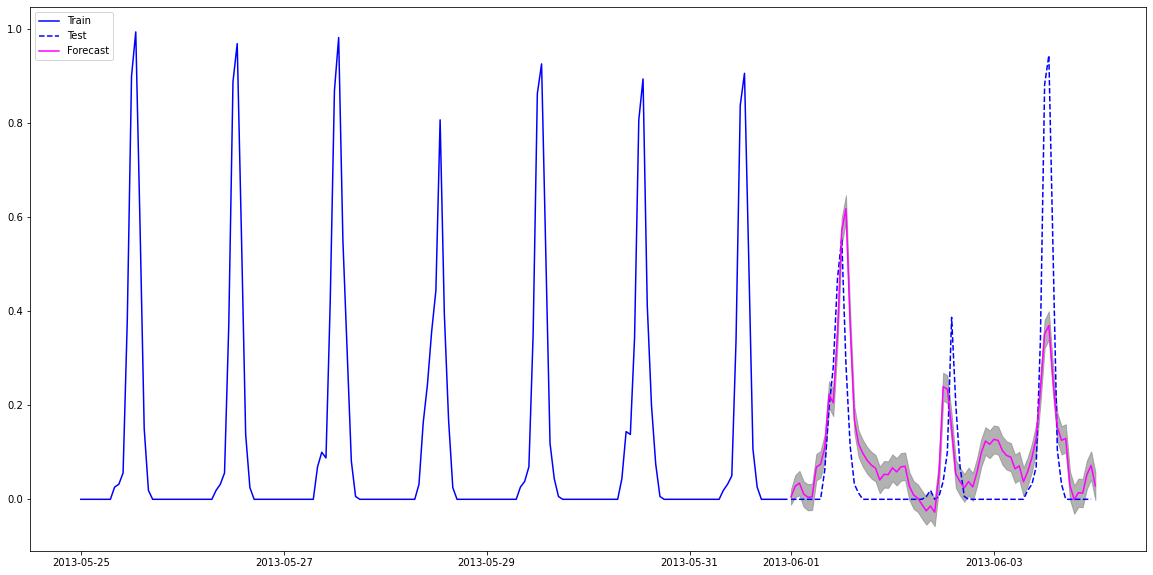

In [31]:
predict_plot(sarimax_1_0_1_1_0_1_24, df_train_resample, df_test_resample, 24*7, 24 * 3, columns_exog)

In [32]:
aic = sarimax_1_0_1_1_0_1_24.aic
rmse = get_RMSE(sarimax_1_0_1_1_0_1_24, df_test_resample, 24 * 3, columns_exog)

put_model_result(dfModelsResults, "SARIMAX (1,0,1)(1,0,1,24)", aic, fin-inicio, rmse)

,Model,AIC,RMSE,Time
0,"ARIMA(3, 0, 1)",-7289.68708,0.252485,19.24858
1,"SARIMAX (1,0,1)(1,0,0,24)",-9005.564161,0.153444,206.57056
2,"SARIMAX (1,0,1)(1,0,1,24)",-9843.266906,0.132942,223.055913


In [33]:
file_name = '/content/drive/My Drive/solar_panel_models/sarimax_1_0_1_1_0_1_24.pkl'
pickle.dump(sarimax_1_0_1_1_0_1_24, open(file_name, 'wb'))

## SARIMAX (2,0,1)(1,0,1,24) --> AIC -9969.137

In [34]:
columns_exog = ['Temperatura', 'Viento', 'Humedad',
       'Presion_atmosferica', 'Visibilidad', 'Clear', 'Partly_sunny',
       'Passing_clouds', 'Scattered_clouds', 'Sunny']

inicio = time.time()
sarimax_2_0_1_1_0_1_24 = SARIMAX(df_train_resample.Produccion, exog = df_train_resample[columns_exog], order=(2,0,1), seasonal_order=(1, 0, 1, 24)).fit()
fin = time.time()       
print(sarimax_2_0_1_1_0_1_24.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                         Produccion   No. Observations:                 8040
Model:             SARIMAX(2, 0, 1)x(1, 0, 1, 24)   Log Likelihood                5000.569
Date:                            Thu, 16 Feb 2023   AIC                          -9969.137
Time:                                    06:07:05   BIC                          -9857.262
Sample:                                07-01-2012   HQIC                         -9930.854
                                     - 05-31-2013                                         
Covariance Type:                              opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Temperatura             0.0222      0.001     16.845      0.000       0.020       0.025
Viento  

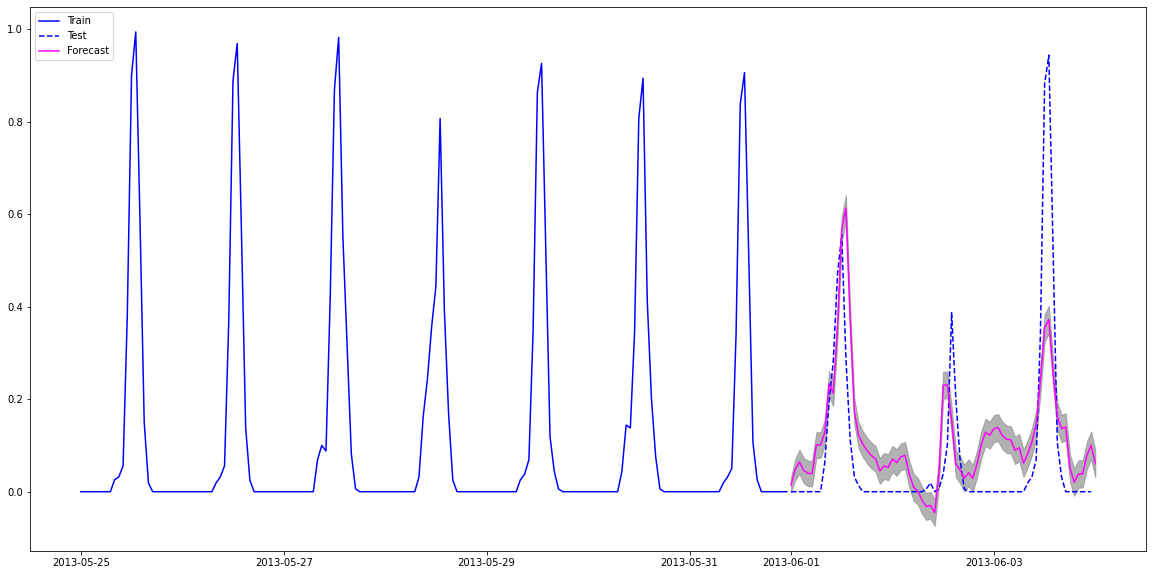

In [35]:
predict_plot(sarimax_2_0_1_1_0_1_24, df_train_resample, df_test_resample, 24*7, 24 * 3, columns_exog)

In [36]:
aic = sarimax_2_0_1_1_0_1_24.aic
rmse = get_RMSE(sarimax_2_0_1_1_0_1_24, df_test_resample, 24 * 3, columns_exog)

put_model_result(dfModelsResults, "SARIMAX (2,0,1)(1,0,1,24)", aic, fin-inicio, rmse)

,Model,AIC,RMSE,Time
0,"ARIMA(3, 0, 1)",-7289.68708,0.252485,19.24858
1,"SARIMAX (1,0,1)(1,0,0,24)",-9005.564161,0.153444,206.57056
2,"SARIMAX (1,0,1)(1,0,1,24)",-9843.266906,0.132942,223.055913
3,"SARIMAX (2,0,1)(1,0,1,24)",-9969.137093,0.136647,200.347122


In [37]:
file_name = '/content/drive/My Drive/solar_panel_models/sarimax_2_0_1_1_0_1_24.pkl'
pickle.dump(sarimax_2_0_1_1_0_1_24, open(file_name, 'wb'))


## SARIMAX (3,0,1)(1,0,1,24) --> AIC -9677.436

In [38]:
columns_exog = ['Temperatura', 'Viento', 'Humedad',
       'Presion_atmosferica', 'Visibilidad', 'Clear', 'Partly_sunny',
       'Passing_clouds', 'Scattered_clouds', 'Sunny']

inicio = time.time()
sarimax_3_0_1_1_0_1_24 = SARIMAX(df_train_resample.Produccion, exog = df_train_resample[columns_exog], order=(3,0,1), seasonal_order=(1, 0, 1, 24)).fit()
fin = time.time()
file_name = '/content/drive/My Drive/solar_panel_models/sarimax_3_0_1_1_0_1_24.pkl'
pickle.dump(sarimax_3_0_1_1_0_1_24, open(file_name, 'wb'))   
print(sarimax_3_0_1_1_0_1_24.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                         Produccion   No. Observations:                 8040
Model:             SARIMAX(3, 0, 1)x(1, 0, 1, 24)   Log Likelihood                4855.718
Date:                            Thu, 16 Feb 2023   AIC                          -9677.436
Time:                                    06:11:36   BIC                          -9558.569
Sample:                                07-01-2012   HQIC                         -9636.760
                                     - 05-31-2013                                         
Covariance Type:                              opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Temperatura             0.0034      0.001      2.271      0.023       0.000       0.006
Viento  

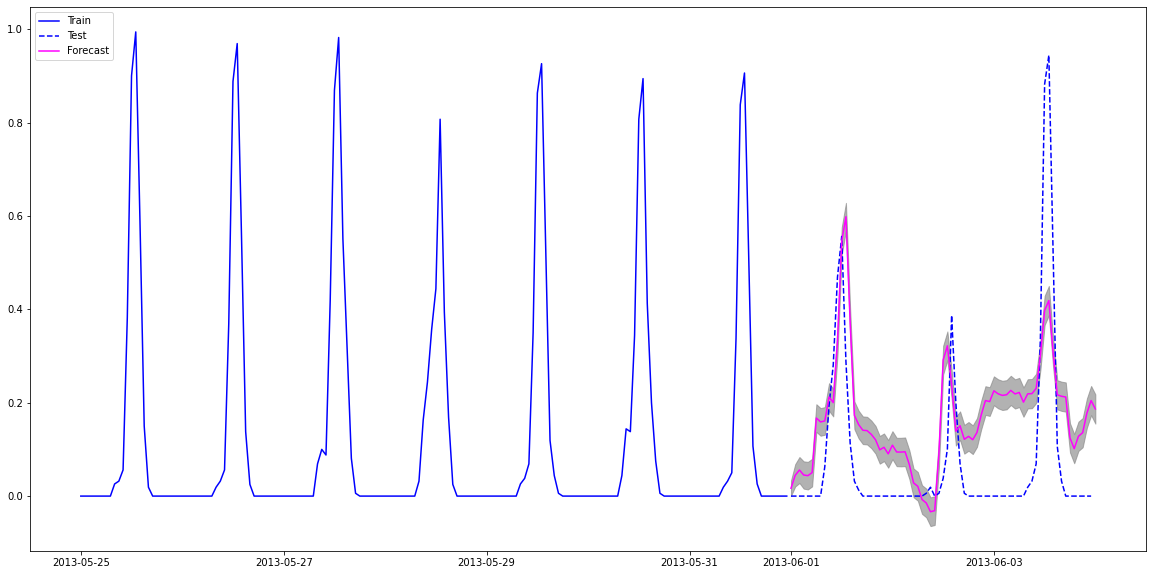

In [39]:
predict_plot(sarimax_3_0_1_1_0_1_24, df_train_resample, df_test_resample, 24*7, 24 * 3, columns_exog)

In [40]:
aic = sarimax_3_0_1_1_0_1_24.aic
rmse = get_RMSE(sarimax_3_0_1_1_0_1_24, df_test_resample, 24 * 3, columns_exog)

put_model_result(dfModelsResults, "SARIMAX (3,0,1)(1,0,1,24)", aic, fin-inicio, rmse)

,Model,AIC,RMSE,Time
0,"ARIMA(3, 0, 1)",-7289.68708,0.252485,19.24858
1,"SARIMAX (1,0,1)(1,0,0,24)",-9005.564161,0.153444,206.57056
2,"SARIMAX (1,0,1)(1,0,1,24)",-9843.266906,0.132942,223.055913
3,"SARIMAX (2,0,1)(1,0,1,24)",-9969.137093,0.136647,200.347122
4,"SARIMAX (3,0,1)(1,0,1,24)",-9677.436025,0.168849,227.190925


## SARIMAX (3,0,1)(2,0,1,24) --> AIC -10704.649

In [41]:
columns_exog = ['Temperatura', 'Viento', 'Humedad',
       'Presion_atmosferica', 'Visibilidad', 'Clear', 'Partly_sunny',
       'Passing_clouds', 'Scattered_clouds', 'Sunny']

inicio = time.time()
sarimax_3_0_1_2_0_1_24 = SARIMAX(df_train_resample.Produccion, exog = df_train_resample[columns_exog], order=(3,0,1), seasonal_order=(2, 0, 1, 24)).fit()
fin = time.time()
file_name = '/content/drive/My Drive/solar_panel_models/sarimax_3_0_1_2_0_1_24.pkl'
pickle.dump(sarimax_3_0_1_2_0_1_24, open(file_name, 'wb'))
print(sarimax_3_0_1_2_0_1_24.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                         Produccion   No. Observations:                 8040
Model:             SARIMAX(3, 0, 1)x(2, 0, 1, 24)   Log Likelihood                5370.325
Date:                            Thu, 16 Feb 2023   AIC                         -10704.649
Time:                                    06:25:01   BIC                         -10578.790
Sample:                                07-01-2012   HQIC                        -10661.581
                                     - 05-31-2013                                         
Covariance Type:                              opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Temperatura             0.0193      0.001     12.958      0.000       0.016       0.022
Viento  

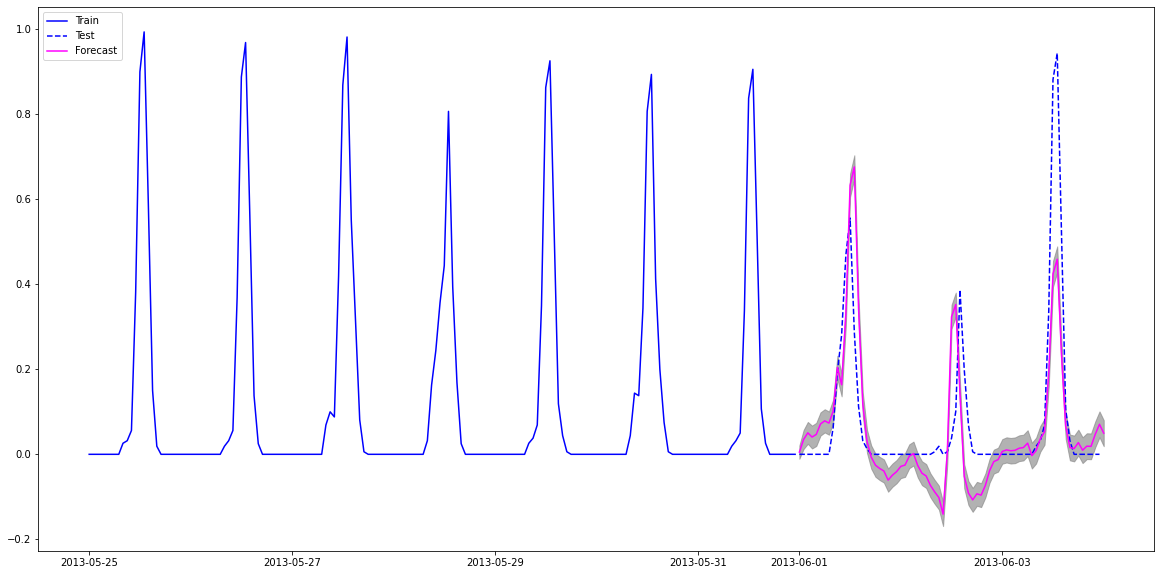

In [42]:
predict_plot(sarimax_3_0_1_2_0_1_24, df_train_resample, df_test_resample, 24*7, 24 * 3, columns_exog)

In [1]:
aic = sarimax_3_0_1_2_0_1_24.aic
rmse = get_RMSE(sarimax_3_0_1_2_0_1_24, df_test_resample, 24 * 3, columns_exog)

put_model_result(dfModelsResults, "SARIMAX (3,0,1)(2,0,1,24)", aic, fin-inicio, rmse)

NameError: ignored

## SARIMAX (3,0,1)(2,0,2,24) --> AIC -10889.624


In [7]:
columns_exog = ['Temperatura', 'Viento', 'Humedad',
       'Presion_atmosferica', 'Visibilidad', 'Clear', 'Partly_sunny',
       'Passing_clouds', 'Scattered_clouds', 'Sunny']

inicio = time.time()
sarimax_3_0_1_2_0_2_24 = SARIMAX(df_train_resample.Produccion, exog = df_train_resample[columns_exog], order=(3,0,1), seasonal_order=(2, 0, 2, 24)).fit()
fin = time.time()    
file_name = '/content/drive/My Drive/solar_panel_models/sarimax_3_0_1_2_0_2_24.pkl'
pickle.dump(sarimax_3_0_1_2_0_2_24, open(file_name, 'wb'))   
print(sarimax_3_0_1_2_0_2_24.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                        SARIMAX Results                                        
Dep. Variable:                              Produccion   No. Observations:                 8040
Model:             SARIMAX(3, 0, 1)x(2, 0, [1, 2], 24)   Log Likelihood                5463.812
Date:                                 Thu, 16 Feb 2023   AIC                         -10889.624
Time:                                         13:54:18   BIC                         -10756.773
Sample:                                     07-01-2012   HQIC                        -10844.163
                                          - 05-31-2013                                         
Covariance Type:                                   opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Temperatura             0.0128      0.001      8.950    

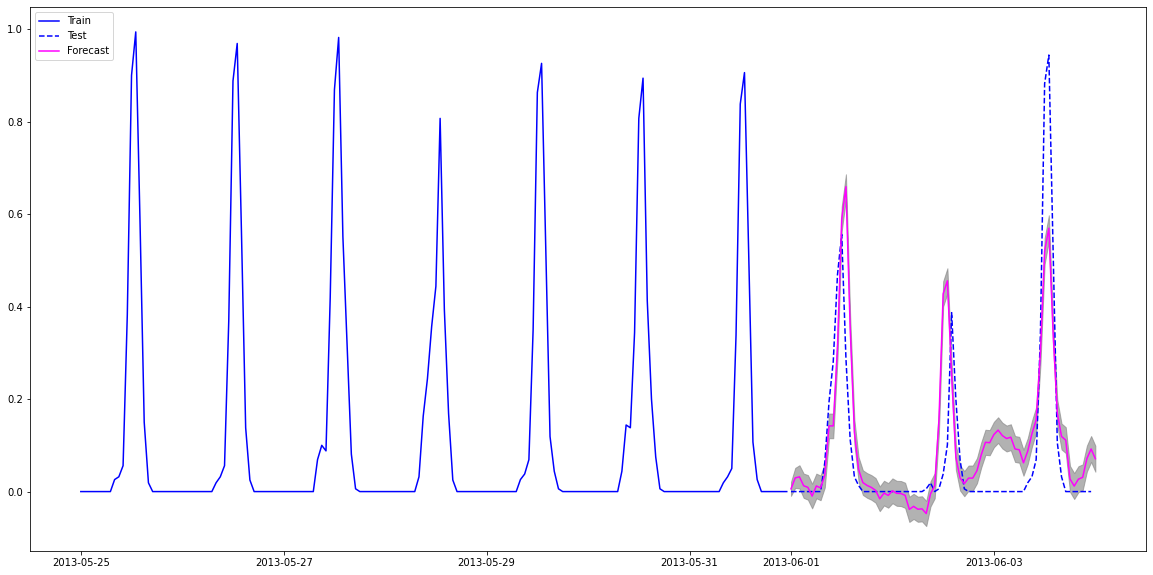

In [10]:
predict_plot(sarimax_3_0_1_2_0_2_24, df_train_resample, df_test_resample, 24*7, 24 * 3, columns_exog)

In [9]:
aic = sarimax_3_0_1_2_0_2_24.aic
rmse = get_RMSE(sarimax_3_0_1_2_0_2_24, df_test_resample, 24 * 3, columns_exog)

put_model_result(dfModelsResults, "SARIMAX (3,0,1)(2,0,2,24)", aic, fin-inicio, rmse)

,Model,AIC,RMSE,Time
0,"SARIMAX (3,0,1)(2,0,2,24)",-10889.624427,0.122838,518.250024


## SARIMAX (3,0,1)(3,0,2,24) --> NO CONVERGE

In [ ]:
columns_exog = ['Temperatura', 'Viento', 'Humedad',
       'Presion_atmosferica', 'Visibilidad', 'Clear', 'Partly_sunny',
       'Passing_clouds', 'Scattered_clouds', 'Sunny']

inicio = time.time()
sarimax_3_0_1_3_0_2_24 = SARIMAX(df_train_resample.Produccion, exog = df_train_resample[columns_exog], order=(3,0,1), seasonal_order=(3, 0, 2, 24)).fit()
fin = time.time()    
file_name = '/content/drive/My Drive/solar_panel_models/sarimax_3_0_1_3_0_2_24.pkl'
pickle.dump(sarimax_3_0_1_3_0_2_24, open(file_name, 'wb'))   
print(sarimax_3_0_1_3_0_2_24.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
predict_plot(sarimax_3_0_1_3_0_2_24, df_train_resample, df_test_resample, 24*7, 24 * 3, columns_exog)

In [ ]:
aic = sarimax_3_0_1_3_0_2_24.aic
rmse = get_RMSE(sarimax_3_0_1_3_0_2_24, df_test_resample, 24 * 3, columns_exog)

put_model_result(dfModelsResults, "SARIMAX (3,0,1)(3,0,2,24)", aic, fin-inicio, rmse)

## SARIMAX (3,0,1)(2,0,3,24) --> Se supero la cuota de almacenamiento

In [ ]:
columns_exog = ['Temperatura', 'Viento', 'Humedad',
       'Presion_atmosferica', 'Visibilidad', 'Clear', 'Partly_sunny',
       'Passing_clouds', 'Scattered_clouds', 'Sunny']

inicio = time.time()
sarimax_3_0_1_2_0_3_24 = SARIMAX(df_train_resample.Produccion, exog = df_train_resample[columns_exog], order=(3,0,1), seasonal_order=(2, 0, 3, 24)).fit()
fin = time.time()    
file_name = '/content/drive/My Drive/solar_panel_models/sarimax_3_0_1_3_0_2_24.pkl'
pickle.dump(sarimax_3_0_1_2_0_3_24, open(file_name, 'wb'))   
print(sarimax_3_0_1_2_0_3_24.summary())

In [1]:
predict_plot(sarimax_3_0_1_2_0_3_24, df_train_resample, df_test_resample, 24*7, 24 * 3, columns_exog)

NameError: ignored

In [ ]:
aic = sarimax_3_0_1_2_0_3_24.aic
rmse = get_RMSE(sarimax_3_0_1_2_0_3_24, df_test_resample, 24 * 3, columns_exog)

put_model_result(dfModelsResults, "SARIMAX (3,0,1)(2,0,3,24)", aic, fin-inicio, rmse)

## LSTM

In [17]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [18]:
# convertimos un array de valores en una matriz de conjuntos de datos
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return numpy.array(dataX), numpy.array(dataY)

In [19]:
# semilla aleatoria para reproducibilidad
numpy.random.seed(7)

dataset = df_join_resample['Produccion']

# dividimos entre entrenamiento y test
train = df_train_24.Produccion.values.reshape(-1, 1)
test = df_test_24.Produccion.values.reshape(-1, 1)
validation = df_validation_24.Produccion.values.reshape(-1, 1)


# normalizamos el conjunto de datos
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)
test = scaler.fit_transform(test)
validation = scaler.fit_transform(validation)

# remodelamos X=t y Y=t+1
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
validationX, validationY = create_dataset(validation, look_back)

# remodelamos la entrada para que sea[muestras, pasos de tiempo, características]
trainX = trainX.reshape(trainX.shape[0], look_back, -1)
testX = testX.reshape(testX.shape[0], look_back, -1)
validationX = validationX.reshape(validationX.shape[0], look_back, -1)


In [10]:
file_name = '/content/drive/My Drive/solar_panel_models/scaler.pkl'
pickle.dump(scaler, open(file_name, 'wb'))

In [109]:
#creamos la LSTM network
model = Sequential()
model.add(LSTM(6, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
7410/7410 - 28s - loss: 0.0153 - 28s/epoch - 4ms/step
Epoch 2/10
7410/7410 - 23s - loss: 0.0092 - 23s/epoch - 3ms/step
Epoch 3/10
7410/7410 - 22s - loss: 0.0089 - 22s/epoch - 3ms/step
Epoch 4/10
7410/7410 - 23s - loss: 0.0086 - 23s/epoch - 3ms/step
Epoch 5/10
7410/7410 - 22s - loss: 0.0082 - 22s/epoch - 3ms/step
Epoch 6/10
7410/7410 - 24s - loss: 0.0079 - 24s/epoch - 3ms/step
Epoch 7/10
7410/7410 - 22s - loss: 0.0076 - 22s/epoch - 3ms/step
Epoch 8/10
7410/7410 - 23s - loss: 0.0075 - 23s/epoch - 3ms/step
Epoch 9/10
7410/7410 - 24s - loss: 0.0074 - 24s/epoch - 3ms/step
Epoch 10/10
7410/7410 - 24s - loss: 0.0074 - 24s/epoch - 3ms/step


In [117]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor


# remodelamos X=t y Y=t+1
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
validationX, validationY = create_dataset(validation, look_back)

# remodelamos la entrada para que sea[muestras, pasos de tiempo, características]
trainX = trainX.reshape(trainX.shape[0], look_back, -1)
testX = testX.reshape(testX.shape[0], look_back, -1)
validationX = validationX.reshape(validationX.shape[0], look_back, -1)

# Función para crear modelo de red LSTM
def create_model(num_layers, num_units):
    model = Sequential()
    for i in range(num_layers):
        if i == 0:
            model.add(LSTM(num_units, input_shape=(look_back, 1), return_sequences=True))
        elif i == num_layers - 1:
            model.add(LSTM(num_units))
        else:
            model.add(LSTM(num_units, return_sequences=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Crear modelo envuelto en KerasRegressor para su uso en GridSearchCV
model = KerasRegressor(build_fn=create_model, verbose=0)

# Definir valores para los hiperparámetros
num_layers = [1, 2]
num_units = [4, 8]
batch_size = [1, 2]
epochs = [5, 10]

# Crear diccionario de parámetros a ser explorados
param_grid = dict(num_layers=num_layers, num_units=num_units, batch_size=batch_size, epochs=epochs)

# Realizar búsqueda de cuadrícula
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(trainX, trainY)

# Imprimir resultados
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


<ipython-input-117-b29631b553fb>:33: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)
/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best: -0.007593 using {'batch_size': 2, 'epochs': 10, 'num_layers': 2, 'num_units': 8}


In [10]:
#creamos la LSTM network
model = Sequential()
model.add(LSTM(8, input_shape=(look_back, 1), return_sequences=True))
model.add(LSTM(8))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=2, verbose=2)

Epoch 1/10
3705/3705 - 18s - loss: 0.0187 - 18s/epoch - 5ms/step
Epoch 2/10
3705/3705 - 15s - loss: 0.0090 - 15s/epoch - 4ms/step
Epoch 3/10
3705/3705 - 15s - loss: 0.0082 - 15s/epoch - 4ms/step
Epoch 4/10
3705/3705 - 15s - loss: 0.0079 - 15s/epoch - 4ms/step
Epoch 5/10
3705/3705 - 16s - loss: 0.0077 - 16s/epoch - 4ms/step
Epoch 6/10
3705/3705 - 15s - loss: 0.0076 - 15s/epoch - 4ms/step
Epoch 7/10
3705/3705 - 15s - loss: 0.0075 - 15s/epoch - 4ms/step
Epoch 8/10
3705/3705 - 15s - loss: 0.0074 - 15s/epoch - 4ms/step
Epoch 9/10
3705/3705 - 17s - loss: 0.0074 - 17s/epoch - 5ms/step
Epoch 10/10
3705/3705 - 15s - loss: 0.0074 - 15s/epoch - 4ms/step


In [11]:
# hacemos las predicciones
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
validationPredict = model.predict(validationX)

# invertimos las predicciones
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
validationPredict = scaler.inverse_transform(validationPredict)
validationY = scaler.inverse_transform([validationY])

# calculamos el error rms
rmse_train = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Resultado del entrenamiento: %.2f RMSE' % (rmse_train))
rmse_test = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Resultado del test: %.2f RMSE' % (rmse_test))
rmse_validation = math.sqrt(mean_squared_error(validationY[0], validationPredict[:,0]))
print('Resultado del validation: %.2f RMSE' % (rmse_validation))

# 253/253 [==============================] - 2s 3ms/step
# 11/11 [==============================] - 0s 2ms/step
# 11/11 [==============================] - 0s 2ms/step
# Resultado del entrenamiento: 0.07 RMSE
# Resultado del test: 0.08 RMSE
# Resultado del validation: 0.14 RMSE

21/21 [==============================] - 0s 2ms/step
Resultado del entrenamiento: 0.08 RMSE
Resultado del test: 0.10 RMSE
Resultado del validation: 0.09 RMSE


In [12]:
model_LSTM_BatchSize_2_Epochs_10_NumLayers_2_NumUnits_8 = model
file_name = '/content/drive/My Drive/solar_panel_models/LSTM_BatchSize_2_Epochs_10_NumLayers_2_NumUnits_8.pkl'
pickle.dump(model_LSTM_BatchSize_2_Epochs_10_NumLayers_2_NumUnits_8, open(file_name, 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
......lstm_1
.........cell
............vars
...............0
...............1
...............2
.........vars
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
variables.h5                                   2023-02-21 18:48:41        36632
config.json                                    2023-02-21 18:48:41         2628
metadata.json                                  2023-02-21 18:48:41           64


In [30]:
# predicciones del entrenamiento de cambio para plotear
trainPredictPlot = numpy.empty_like(dataset)
#trainPredictPlot[:, :] = numpy.nan
trainPredictPlot = numpy.full((8760,), numpy.nan)
trainPredictPlot[look_back : len(trainPredict)+look_back, ] = trainPredict.reshape(-1,)

# predicciones del test de cambio para plotear
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot = numpy.full((8760,), numpy.nan)
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, ] = testPredict.reshape(-1,)

# plot baseline and predictions
periods_before = 24*3
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(scaler.inverse_transform(dataset.values.reshape(-1, 1))[train_size-periods_before:])

# ploteamos linea base y predicciones
ax.plot(pd.DataFrame(trainPredictPlot[train_size-periods_before:]),'r', linewidth = 2)
ax.plot(pd.DataFrame(testPredictPlot[train_size-periods_before:]),'m', linewidth = 2)
ax.legend(('Datos', 'Prediccion datos entramiento', 'Prediccion sobre los datos de test'), loc='upper left')
ax.grid(True)
ax.set_title("Datos generacion de energia mediante paneles solares", fontsize=15)
ax.set_xlabel("Tiempo (nº horas)", fontsize=10)
ax.set_ylabel("Cantidad de energia generada", fontsize=10)
plt.show()


ValueError: ignored

In [39]:
Con estos conjuntos de datos, quiero graficar en tamaño figsize(20,10) los datos reales vs los predichos en train test y validation

trainX, trainY = create_dataset(train, look_back)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
validationPredict = scaler.inverse_transform(validationPredict)
validationY = scaler.inverse_transform([validationY])

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fa592b25ee0> (for post_execute):


ValueError: ignored

ValueError: ignored

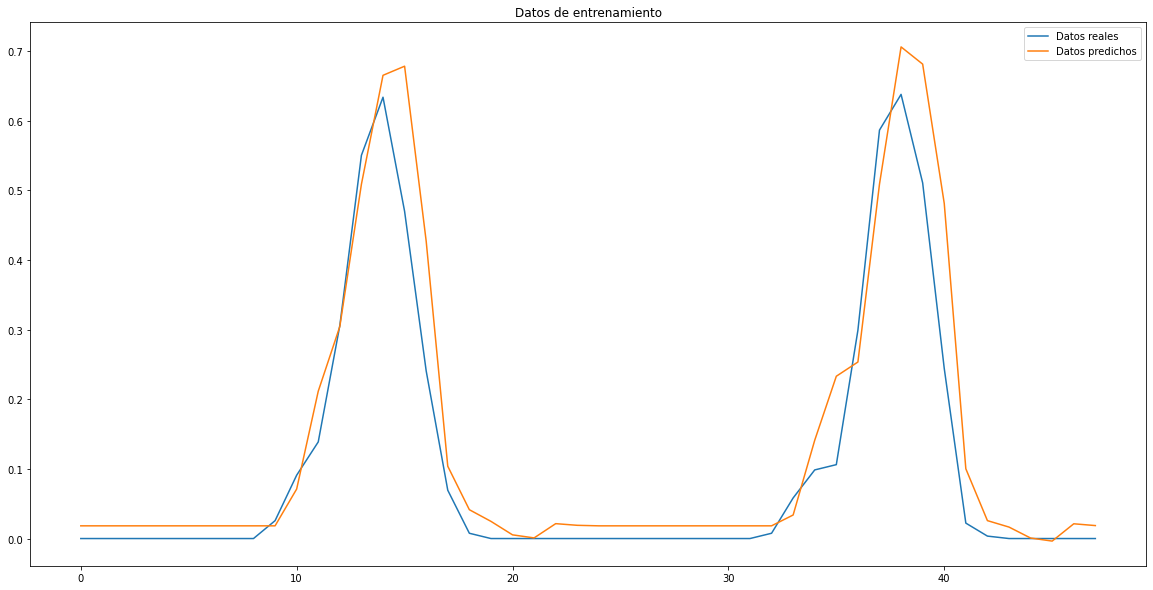

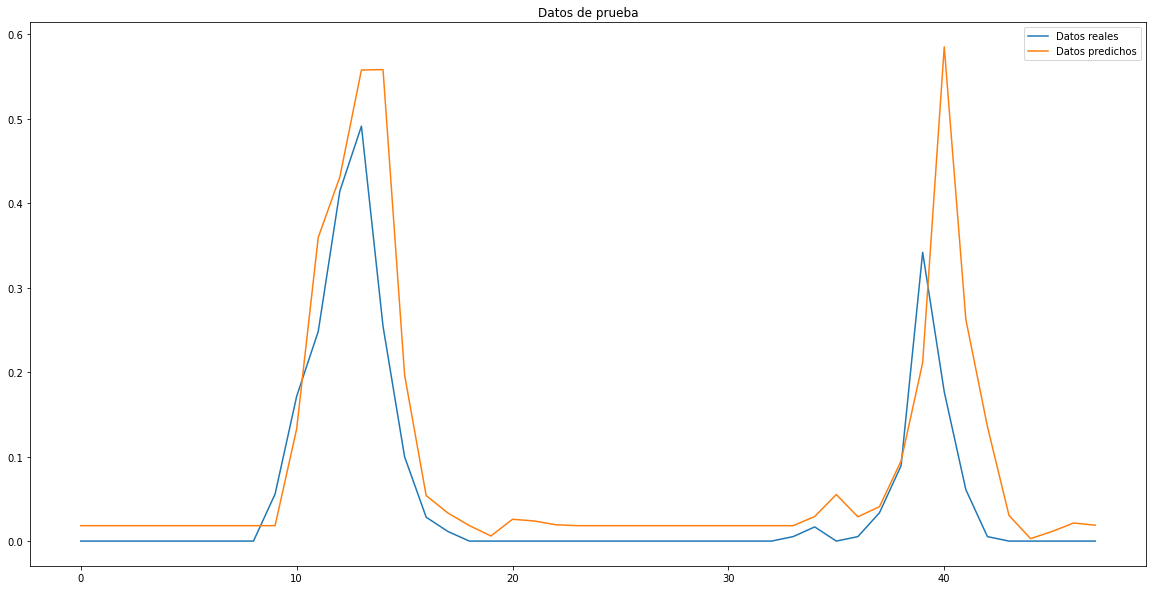

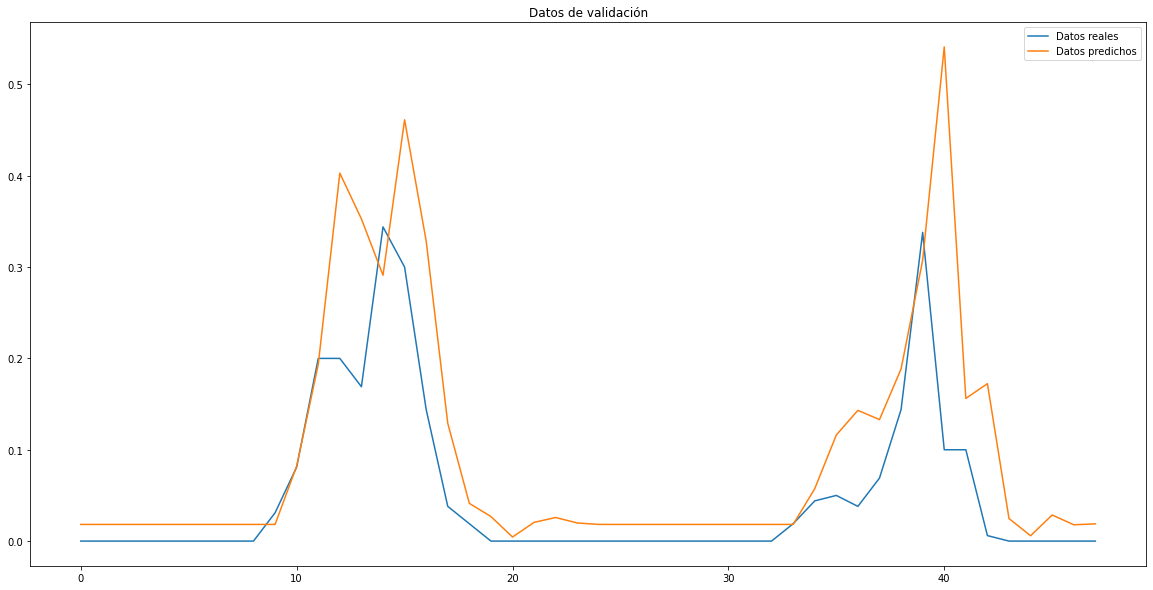

In [113]:
import matplotlib.pyplot as plt

ultimosN = 24 * 2

# Gráfico de datos de entrenamiento
plt.figure(figsize=(20,10))
plt.plot(trainY.flatten()[-ultimosN:], label='Datos reales') # Graficar solo los últimos N puntos de trainY
plt.plot(trainPredict.flatten()[-ultimosN:], label='Datos predichos') # Graficar solo los últimos N puntos de trainPredict
plt.title('Datos de entrenamiento')
plt.legend()
plt.show()


# Gráfico de datos de prueba
plt.figure(figsize=(20,10))
plt.plot(testY.flatten()[-ultimosN:], label='Datos reales')
plt.plot(testPredict.flatten()[-ultimosN:], label='Datos predichos')
plt.title('Datos de prueba')
plt.legend()
plt.show()

# Gráfico de datos de validación
plt.figure(figsize=(20,10))
plt.plot(validationY.flatten()[-ultimosN:], label='Datos reales')
plt.plot(validationPredict.flatten()[-ultimosN:], label='Datos predichos')
plt.title('Datos de validación')
plt.legend()
plt.show()



In [ ]:
Estos son los 3 graficos originales.
Los datos pertenecen a una serie de tiempo en donde train esta antes que test, y validation antes que test. quiero que los 3 conjuntos de datos esten ploteados en el mismo grafico como una unica linea

import matplotlib.pyplot as plt

ultimosN = 24*7*4

# Gráfico de datos de entrenamiento
plt.figure(figsize=(20,10))
plt.plot(trainY.flatten()[-ultimosN:], label='Datos reales') # Graficar solo los últimos N puntos de trainY
plt.plot(trainPredict.flatten()[-ultimosN:], label='Datos predichos') # Graficar solo los últimos N puntos de trainPredict
plt.title('Datos de entrenamiento')
plt.legend()
plt.show()


# Gráfico de datos de prueba
plt.figure(figsize=(20,10))
plt.plot(testY.flatten(), label='Datos reales')
plt.plot(testPredict.flatten(), label='Datos predichos')
plt.title('Datos de prueba')
plt.legend()
plt.show()

# Gráfico de datos de validación
plt.figure(figsize=(20,10))
plt.plot(validationY.flatten(), label='Datos reales')
plt.plot(validationPredict.flatten(), label='Datos predichos')
plt.title('Datos de validación')
plt.legend()
plt.show()



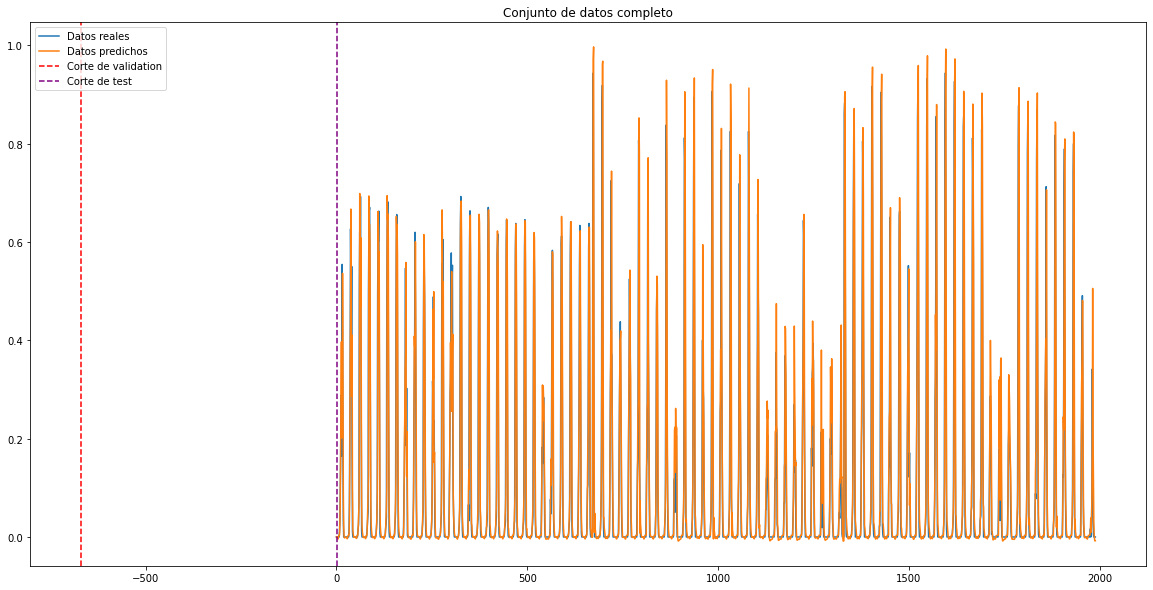

In [92]:
import matplotlib.pyplot as plt
import numpy as np

ultimosN = 24*7*4

# Concatenar los arrays de train, validation y test
y = np.concatenate((trainY.flatten()[-ultimosN:], validationY.flatten()[-ultimosN:], testY.flatten()), axis=0)

# Concatenar los arrays de train_predict, validation_predict y test_predict
y_pred = np.concatenate((trainPredict.flatten()[-ultimosN:], validationPredict.flatten()[-ultimosN:], testPredict.flatten()), axis=0)

# Gráfico de la serie completa
plt.figure(figsize=(20,10))
plt.plot(y, label='Datos reales')
plt.plot(y_pred, label='Datos predichos')
plt.title('Conjunto de datos completo')
plt.legend()

# Agregar líneas verticales en los cortes de test y validation
plt.axvline(len(trainY) + len(validationY) - ultimosN, color='red', linestyle='--', label='Corte de validation')
plt.axvline(len(trainY) + len(validationY), color='purple', linestyle='--', label='Corte de test')
plt.legend()

plt.show()


In [93]:
y.shape

(1990,)